# Определение возраста покупателей

Цель проекта: 

Построть модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Этапы проекта:
* Провести исследовательский анализ набора фотографий.
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитайте её качество.



## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
-------------------------------
Распределение
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000
-------------------------------


Text(0, 0.5, 'Количество')

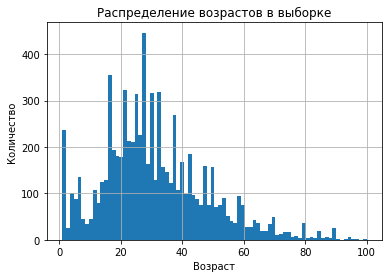

In [6]:
print('Общая информация')
print(labels.info())
print('-'*31)
print('Распределение')
print(labels.describe())
print('-'*31)
labels['real_age'].hist(bins=80)
plt.title('Распределение возрастов в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')

* Выборка состоит из 7591 фотографий
* Гистограмма показала что на фото, доля от общего количества, преимущественно людей от 18 до 35 лет, а значит именно этот возраст будет лучше всего предсказывать модель

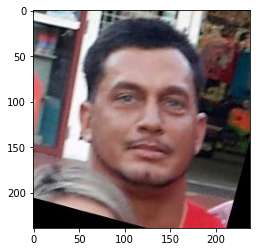

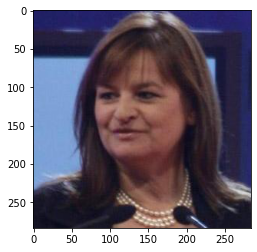

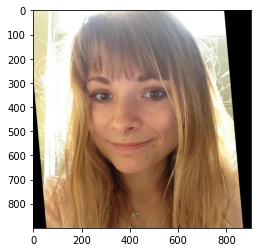

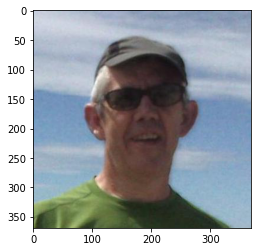

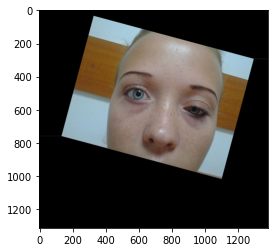

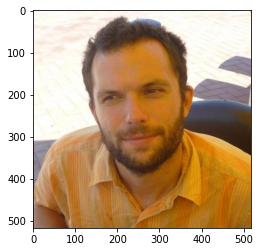

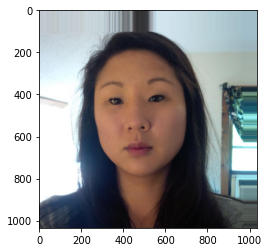

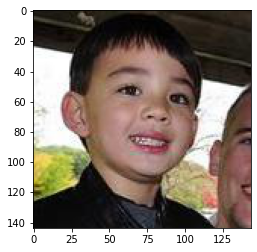

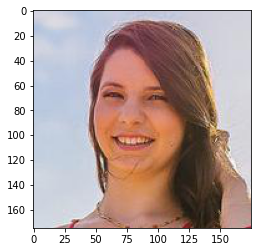

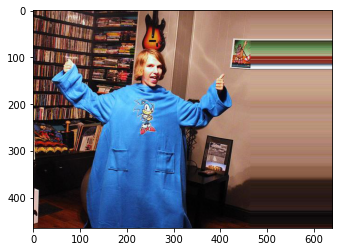

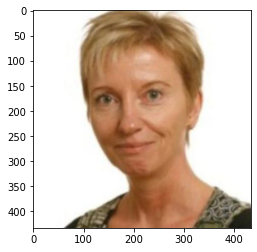

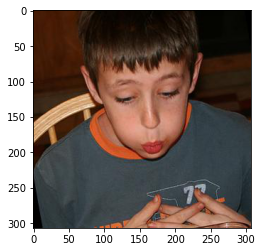

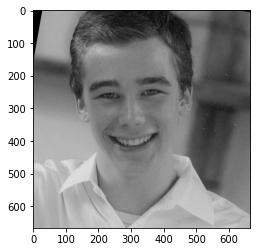

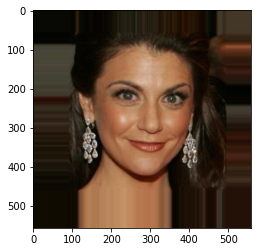

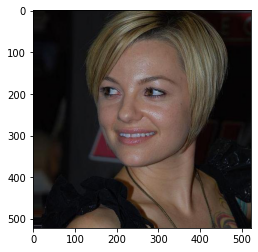

In [5]:
photo = os.listdir('/datasets/faces/final_files/')
for i in random.sample(photo, k=15):
    image = Image.open('/datasets/faces/final_files/' + i)
    plt.imshow(np.array(image))
    plt.show()

Вывели на эклан 15 случайных фото, на которых видно что не все фотографии хорошего качества, а значит модели будет сложнее обучиться. 
Модель лучше всего будет предсказывать возвраст людей от 18 до 35 лет, не все фотографии хорошего качества

## Обучение модели

In [6]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))     
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-04-20 13:01:12.134570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-20 13:01:12.427060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 50s - loss: 191.0529 - mae: 10.2358 - val_loss: 335.8320 - val_mae: 13.5865
Epoch 2/10
356/356 - 56s - loss: 98.6419 - mae: 7.5221 - val_loss: 302.6327 - val_mae: 13.4819
Epoch 3/10
356/356 - 55s - loss: 73.8552 - mae: 6.5292 - val_loss: 82.3147 - val_mae: 6.9239
Epoch 4/10
356/356 - 56s - loss: 54.7180 - mae: 5.6281 - val_loss: 89.6558 - val_mae: 7.2678
Epoch 5/10
356/356 - 57s - loss: 44.6154 - mae: 5.1135 - val_loss: 81.6559 - val_mae: 6.7502
Epoch 6/10
356/356 - 57s - loss: 33.8173 - mae: 4.4552 - val_loss: 97.0710 - val_mae: 7.8136
Epoch 7/10
356/356 - 42s - loss: 27.9887 - mae: 4.0620 - val_loss: 107.7584 - val_mae: 7.7894
Epoch 8/10
356/356 - 43s - loss: 25.1161 - mae: 3.8434 - val_loss: 79.8997 - val_mae: 6.6170
Epoch 9/10
356/356 - 45s - loss: 20.0783 - mae: 3.4331 - val_loss: 71.0561 - val_mae: 6.3424
Epoch 10/10
356/356 - 46s - loss: 17.2658 - mae: 3.1854 - val_loss: 69.6416 - val_mae: 6.2357
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 69.6416 - mae: 6.2357
Test MAE: 6.2357

```

## Анализ обученной модели

После обучения нейронной сети добились значения MAE на тестовой выборке 6.2357, для этого:
* применили архитектуру ResNet50.
* обучили модель на 10 эпохах 

По результатам можно сделать вывод:
* модель не переобучалась, так как показатели улучшались и на обучающей выборке и на тестовой, а значит она подходит для определения возраста покупателей
* вероятность ошибки присутствует со значимой погрешностью определения возраста, а значит для определения совершеннолетия при продаже алкоголя требуется дополнительная проверка
* думаю можно добиться еще более высокого показалеля эффективности.